# 🎧 DBSCAN Clustering — **Song Mood / Production Typology (Global)**

**Versi v3 — DBSCAN Mode:**  
- **DBSCAN (Density-Based Spatial Clustering)** untuk clustering berbasis densitas.  
- **Optimasi parameter eps & min_samples** menggunakan k-distance graph & silhouette.  
- **Init dengan normalisasi L2** untuk spherical distance.
- **Deteksi noise/outlier** otomatis oleh DBSCAN.
- Tetap ada **ekspor cleaned dataset** untuk benchmark di **Orange Data Mining**.

## 0) Setup & Konfigurasi

In [1]:
from pathlib import Path

DATA_DIR = Path("data")  # ganti sesuai lokasi ekstraksi CSV Kaggle
MAX_ROWS = 200_000               # set None bila ingin memuat semua
K_MIN, K_MAX = 2, 15             # range K untuk scanning (diperluas untuk melihat elbow lebih jelas)

print("DATA_DIR:", DATA_DIR.resolve())
print("MAX_ROWS:", MAX_ROWS)
print("K range:", (K_MIN, K_MAX))


DATA_DIR: /Users/rimsj/PROJECT/COLLEGE/Machine-Learning/Journal/data
MAX_ROWS: 200000
K range: (2, 15)


## 1) Import Library

In [2]:
import warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

In [3]:
# Install library untuk k-distance analysis (jalankan jika belum terinstall)
# !pip install scikit-learn matplotlib

## 2) Load Dataset (Auto-Detect CSV)

In [4]:
ESSENTIAL_COLS = [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature',
    'name','track_name','artists','artist_name','popularity','year','release_date','id','track_id'
]

def find_spotify_csv(base_dir: Path):
    csvs = list(base_dir.rglob("*.csv"))
    print(f"Ditemukan {len(csvs)} file CSV di {base_dir}.")
    best_path, best_score = None, -1
    for p in csvs:
        try:
            df_head = pd.read_csv(p, nrows=2000, low_memory=False)
        except Exception:
            continue
        cols = set(c.lower() for c in df_head.columns)
        score = sum(int(c in cols) for c in [c.lower() for c in ESSENTIAL_COLS])
        if score > best_score:
            best_score, best_path = score, p
    return best_path

csv_path = find_spotify_csv(DATA_DIR)
if csv_path is None:
    raise FileNotFoundError("Tidak menemukan CSV sesuai. Pastikan DATA_DIR benar.")
print("CSV terpilih:", csv_path)


Ditemukan 1 file CSV di data.
CSV terpilih: data/tracks_features.csv


## 3) Baca Data & Seleksi Kolom

In [5]:
FEATURE_COLS_CANDIDATES = [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
]
META_COLS_CANDIDATES = [
    'name','track_name','artists','artist_name','popularity','year','release_date','id','track_id'
]

sample_head = pd.read_csv(csv_path, nrows=5, low_memory=False)
available_cols = set(sample_head.columns)

rename_map = {}
if 'name' in available_cols and 'track_name' not in available_cols:
    rename_map['name'] = 'track_name'
if 'artist_name' in available_cols and 'artists' not in available_cols:
    rename_map['artist_name'] = 'artists'
if 'id' in available_cols and 'track_id' not in available_cols:
    rename_map['id'] = 'track_id'

usecols = [c for c in FEATURE_COLS_CANDIDATES + META_COLS_CANDIDATES if c in available_cols]
dtype_map = {
    'danceability':'float32','energy':'float32','acousticness':'float32',
    'instrumentalness':'float32','liveness':'float32','speechiness':'float32',
    'valence':'float32','tempo':'float32','loudness':'float32',
    'duration_ms':'int32','key':'int8','mode':'int8','time_signature':'int8',
    'popularity':'int16','year':'int16'
}
df = pd.read_csv(csv_path, usecols=usecols, low_memory=False, dtype={k:v for k,v in dtype_map.items() if k in usecols})
df.rename(columns=rename_map, inplace=True)

if MAX_ROWS is not None and len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)

print("Shape:", df.shape)
df.head(3)


Shape: (200000, 18)


,track_id,track_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,1aGS6nf2xgv3Xzdob4eOO3,Smokin' Sticky Sticky,['Unk'],0.623,0.736,11,-3.657,0,0.4020,0.0021,0.000,0.0691,0.422,87.987999,380427,4,2006,2006-10-03
1,0fJfoqHIIiET2EcgjOfntG,Holding Back the Years,['Norm Douglas'],0.585,0.639,2,-9.641,0,0.0333,0.3160,0.775,0.0993,0.880,170.082001,266520,4,2008,2008-06-13
2,0V2R2LC8dR7S0REieXRaGt,All Along The Watchtower - Live - 1991,['Indigo Girls'],0.331,0.466,9,-14.287,0,0.0379,0.7090,0.000,0.9390,0.430,90.648003,383773,4,1991,1991-06-04


## 4) Pembersihan Data

In [6]:
has_track_id = 'track_id' in df.columns
has_track_name = 'track_name' in df.columns
has_artists = 'artists' in df.columns

if has_track_id:
    df = df.drop_duplicates(subset=['track_id'])
elif has_track_name and has_artists:
    df = df.drop_duplicates(subset=['track_name','artists'])

FEATS = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
] if c in df.columns]

df = df.dropna(subset=FEATS)

if 'tempo' in df.columns:
    df['tempo'] = df['tempo'].clip(30, 250)
if 'loudness' in df.columns:
    df['loudness'] = df['loudness'].clip(-60, 5)
if 'duration_ms' in df.columns:
    df['duration_ms'] = df['duration_ms'].clip(10_000, 900_000)

print("Setelah cleaning:", df.shape)
df[FEATS].describe().T


Setelah cleaning: (200000, 18)


,count,mean,std,min,25%,50%,75%,max
danceability,200000.0,0.493104,0.189581,0.0,0.356000,0.500000,0.63300,0.988000
energy,200000.0,0.509209,0.294888,0.0,0.251000,0.524000,0.76600,1.000000
acousticness,200000.0,0.447151,0.385170,0.0,0.037500,0.389000,0.86200,0.996000
instrumentalness,200000.0,0.282118,0.375982,0.0,0.000008,0.007900,0.71600,1.000000
liveness,200000.0,0.202243,0.181241,0.0,0.096800,0.125000,0.24600,1.000000
speechiness,200000.0,0.084984,0.117246,0.0,0.035100,0.044600,0.07260,0.966000
valence,200000.0,0.428202,0.270427,0.0,0.192000,0.404000,0.64400,1.000000
tempo,200000.0,117.758041,30.807684,30.0,94.017998,116.827503,137.26725,248.934006
loudness,200000.0,-11.811852,6.984575,-60.0,-15.266000,-9.797000,-6.71300,5.000000
duration_ms,200000.0,245332.964735,127085.301128,10000.0,173855.250000,224040.000000,285680.00000,900000.000000


## 5) Feature Engineering & Scaling

In [7]:
work = df.copy()

if 'duration_ms' in work.columns:
    work['duration_s'] = work['duration_ms'] / 1000.0
    work['log_duration_s'] = np.log1p(work['duration_s'])

if 'key' in work.columns:
    import numpy as np
    two_pi = 2*np.pi
    work['key_sin'] = np.sin(two_pi * (work['key'] % 12) / 12.0)
    work['key_cos'] = np.cos(two_pi * (work['key'] % 12) / 12.0)

num_feats = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','log_duration_s','key_sin','key_cos'
] if c in work.columns]
bin_feats = [c for c in ['mode'] if c in work.columns]
cat_small = [c for c in ['time_signature'] if c in work.columns]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

transformers = []
if num_feats:
    transformers.append(("num", StandardScaler(), num_feats))
if bin_feats:
    transformers.append(("bin", "passthrough", bin_feats))
if cat_small:
    transformers.append(("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_small))

preprocess = ColumnTransformer(transformers=transformers, remainder='drop')
X = preprocess.fit_transform(work)
print("Shape X:", X.shape)


Shape X: (200000, 18)


## 5.1) Analisis & Cleaning Korelasi Antar-Fitur

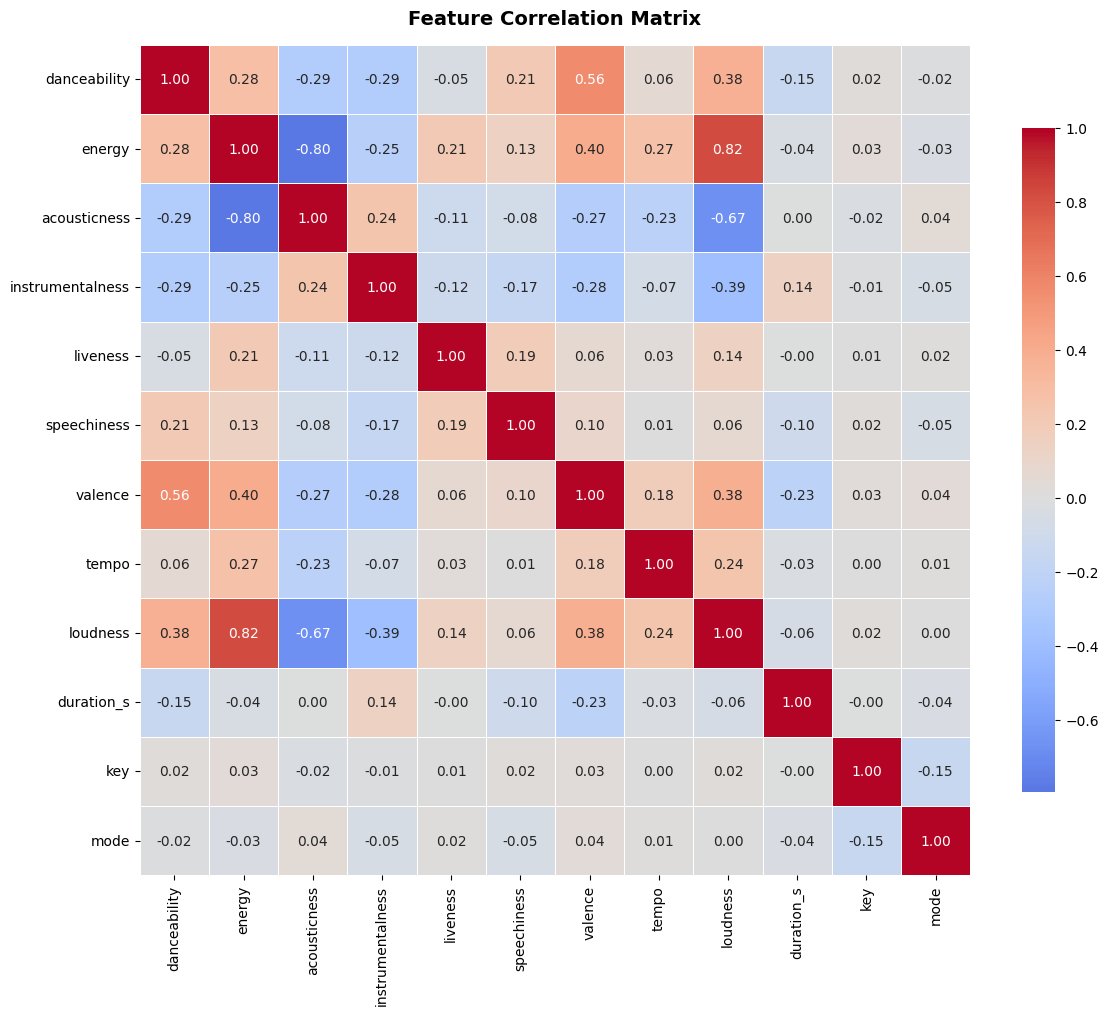


🔍 HIGH CORRELATION PAIRS (|r| > 0.9):
   ✓ No highly redundant features found (all |r| ≤ 0.9)

📊 MODERATE-HIGH CORRELATION PAIRS (0.7 < |r| ≤ 0.9):
   energy ↔ loudness: r = 0.819
   energy ↔ acousticness: r = -0.796


In [8]:
import seaborn as sns

# Hitung correlation matrix untuk fitur numerik
numeric_features = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_s','key','mode'
] if c in work.columns]

corr_matrix = work[numeric_features].corr()

# Visualisasi heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Identifikasi fitur dengan korelasi tinggi (> 0.9)
print("\n" + "="*60)
print("🔍 HIGH CORRELATION PAIRS (|r| > 0.9):")
print("="*60)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)
            print(f"   {pair[0]} ↔ {pair[1]}: r = {pair[2]:.3f}")

if not high_corr_pairs:
    print("   ✓ No highly redundant features found (all |r| ≤ 0.9)")
else:
    print(f"\n⚠️  Found {len(high_corr_pairs)} redundant pair(s) - consider removing one from each pair")

# Identifikasi korelasi moderat-tinggi (0.7 - 0.9) untuk awareness
print("\n" + "="*60)
print("📊 MODERATE-HIGH CORRELATION PAIRS (0.7 < |r| ≤ 0.9):")
print("="*60)

mod_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if 0.7 < abs(corr_matrix.iloc[i, j]) <= 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            mod_corr_pairs.append(pair)

if mod_corr_pairs:
    # Sort by absolute correlation
    mod_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for pair in mod_corr_pairs[:10]:  # Show top 10
        print(f"   {pair[0]} ↔ {pair[1]}: r = {pair[2]:.3f}")
else:
    print("   No moderate-high correlations found")

print("="*60)

## 5.2) Feature Selection & Engineering (Optimized)

In [9]:
# Strategi pemilihan fitur berdasarkan analisis korelasi & domain knowledge
print("="*60)
print("📝 FEATURE SELECTION STRATEGY")
print("="*60)

# Fitur yang PASTI dipakai (core mood/production features)
core_features = [
    'danceability',      # Groove/rhythm
    'energy',            # Intensity
    'acousticness',      # Production style
    'instrumentalness',  # Vocal presence
    'valence',           # Emotional tone
    'speechiness',       # Speech content
]

# Fitur tambahan (production quality)
production_features = [
    'loudness',          # Mix quality
    'tempo',             # BPM
    'log_duration_s',    # Song length (transformed)
]

# Fitur kategorikal yang sudah di-encode
categorical_encoded = [
    'key_sin', 'key_cos',  # Tonal center (circular encoding)
    'mode',                # Major/minor
]

# Fitur yang mungkin redundan/noisy
# - liveness: sering noise, kecuali fokus ke live music
# - time_signature: kebanyakan 4/4, variance rendah
potentially_redundant = ['liveness', 'time_signature']

# Final feature set
selected_features = core_features + production_features + categorical_encoded

print(f"\n✓ Core features ({len(core_features)}): {core_features}")
print(f"✓ Production features ({len(production_features)}): {production_features}")
print(f"✓ Categorical encoded ({len(categorical_encoded)}): {categorical_encoded}")
print(f"⚠️  Potentially redundant/noisy: {potentially_redundant}")
print(f"\n📊 Total selected features: {len(selected_features)}")
print("="*60)

# Verify semua fitur ada di dataframe
selected_features_available = [f for f in selected_features if f in work.columns]
print(f"\n✓ Available features: {len(selected_features_available)}/{len(selected_features)}")
if len(selected_features_available) < len(selected_features):
    missing = set(selected_features) - set(selected_features_available)
    print(f"⚠️  Missing features: {missing}")

SELECTED_FEATURES = selected_features_available

📝 FEATURE SELECTION STRATEGY

✓ Core features (6): ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness']
✓ Production features (3): ['loudness', 'tempo', 'log_duration_s']
✓ Categorical encoded (3): ['key_sin', 'key_cos', 'mode']
⚠️  Potentially redundant/noisy: ['liveness', 'time_signature']

📊 Total selected features: 12

✓ Available features: 12/12


## 5.3) Dimensionality Reduction: PCA 20-30D

Original feature space: (200000, 12)
Features: ['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'speechiness', 'loudness', 'tempo', 'log_duration_s', 'key_sin', 'key_cos', 'mode']


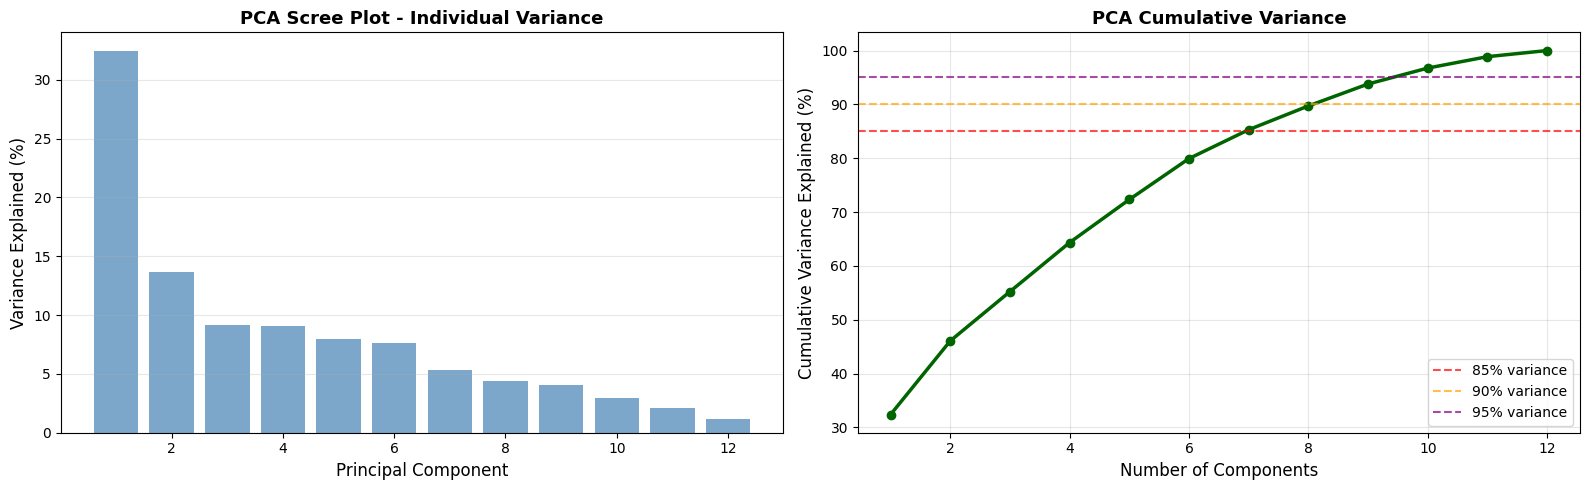


📊 PCA COMPONENT ANALYSIS:
Total available components: 12
Components for 85% variance: 7 (cumvar: 85.30%)
Components for 90% variance: 9 (cumvar: 93.79%)
Components for 95% variance: 10 (cumvar: 96.74%)

💡 Strategy: Using minimum target (12 components)
   ⚠️  Note: Only 12 components available (< 20)

🎯 SELECTED: 12 components (explains 100.00% variance)

✓ PCA transformation complete!
   Input shape: (200000, 12)
   Output shape: (200000, 12)
   Variance explained: 100.00%


In [10]:
# Re-build preprocessing dengan fitur terpilih saja
num_feats_selected = [c for c in SELECTED_FEATURES if c not in ['mode', 'key_sin', 'key_cos']]
bin_feats_selected = [c for c in ['mode'] if c in SELECTED_FEATURES]
cyclic_feats = [c for c in ['key_sin', 'key_cos'] if c in SELECTED_FEATURES]

transformers_v2 = []
if num_feats_selected:
    transformers_v2.append(("num", StandardScaler(), num_feats_selected))
if bin_feats_selected:
    transformers_v2.append(("bin", "passthrough", bin_feats_selected))
if cyclic_feats:
    transformers_v2.append(("cyclic", "passthrough", cyclic_feats))

preprocess_v2 = ColumnTransformer(transformers=transformers_v2, remainder='drop')
X_selected = preprocess_v2.fit_transform(work)

print(f"Original feature space: {X_selected.shape}")
print(f"Features: {SELECTED_FEATURES}")

# PCA untuk dimensionality reduction
# Target: 20-30D yang menjelaskan 85-95% variance
from sklearn.decomposition import PCA

# Scan untuk menemukan n_components optimal
pca_full = PCA(random_state=42)
pca_full.fit(X_selected)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plot scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Individual variance
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
        pca_full.explained_variance_ratio_*100, alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained (%)', fontsize=12)
ax1.set_title('PCA Scree Plot - Individual Variance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Cumulative variance
ax2.plot(range(1, len(cumsum_var)+1), cumsum_var*100, 
         marker='o', linewidth=2.5, markersize=6, color='darkgreen')
ax2.axhline(y=85, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='85% variance')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='90% variance')
ax2.axhline(y=95, color='purple', linestyle='--', linewidth=1.5, alpha=0.7, label='95% variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
ax2.set_title('PCA Cumulative Variance', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal n_components
max_components = len(cumsum_var)  # Maximum available components
n_for_85 = np.argmax(cumsum_var >= 0.85) + 1 if np.any(cumsum_var >= 0.85) else max_components
n_for_90 = np.argmax(cumsum_var >= 0.90) + 1 if np.any(cumsum_var >= 0.90) else max_components
n_for_95 = np.argmax(cumsum_var >= 0.95) + 1 if np.any(cumsum_var >= 0.95) else max_components

print("\n" + "="*60)
print("📊 PCA COMPONENT ANALYSIS:")
print("="*60)
print(f"Total available components: {max_components}")
print(f"Components for 85% variance: {n_for_85} (cumvar: {cumsum_var[n_for_85-1]*100:.2f}%)")
print(f"Components for 90% variance: {n_for_90} (cumvar: {cumsum_var[n_for_90-1]*100:.2f}%)")
print(f"Components for 95% variance: {n_for_95} (cumvar: {cumsum_var[n_for_95-1]*100:.2f}%)")

# Target: 20-30 components (or max available if less)
# Strategi: ambil yang paling mendekati target range sambil maximize variance
target_min = min(20, max_components)
target_max = min(30, max_components)

if target_min <= n_for_90 <= target_max:
    N_COMPONENTS = n_for_90
    print(f"\n💡 Strategy: Using 90% variance threshold")
elif target_min <= n_for_85 <= target_max:
    N_COMPONENTS = n_for_85
    print(f"\n💡 Strategy: Using 85% variance threshold")
elif n_for_85 < target_min:
    # Use all available components if we can't reach target range
    N_COMPONENTS = min(target_min, max_components)
    print(f"\n💡 Strategy: Using minimum target ({N_COMPONENTS} components)")
    if max_components < 20:
        print(f"   ⚠️  Note: Only {max_components} components available (< 20)")
else:  # n_for_85 > target_max
    # Use middle of target range
    N_COMPONENTS = min((target_min + target_max) // 2, max_components)
    print(f"\n💡 Strategy: Using middle of target range")

print(f"\n🎯 SELECTED: {N_COMPONENTS} components (explains {cumsum_var[N_COMPONENTS-1]*100:.2f}% variance)")
print("="*60)

# Apply PCA transformation
pca_reduced = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca_reduced.fit_transform(X_selected)

print(f"\n✓ PCA transformation complete!")
print(f"   Input shape: {X_selected.shape}")
print(f"   Output shape: {X_pca.shape}")
print(f"   Variance explained: {cumsum_var[N_COMPONENTS-1]*100:.2f}%")

## 5.4) Spherical Normalization (L2 untuk Cosine Distance)

In [11]:
from sklearn.preprocessing import normalize

# L2 normalization untuk spherical clustering
# Ini membuat algoritma fokus ke "direction" bukan "magnitude"
# Efektif untuk high-dimensional data & distance-based clustering
X_spherical = normalize(X_pca, norm='l2', axis=1)

print("="*60)
print("🌐 SPHERICAL NORMALIZATION FOR DBSCAN")
print("="*60)
print(f"Data shape: {X_spherical.shape}")
print(f"L2 norm check (should be ~1.0): {np.linalg.norm(X_spherical[0]):.6f}")
print(f"\nSpherical normalization benefits:")
print("  ✓ Focus on feature patterns (direction) rather than magnitude")
print("  ✓ Better for high-dimensional spaces")
print("  ✓ Equivalent to using cosine similarity")
print("  ✓ Often improves clustering quality")
print("="*60)

🌐 SPHERICAL NORMALIZATION FOR DBSCAN
Data shape: (200000, 12)
L2 norm check (should be ~1.0): 1.000000

Spherical normalization benefits:
  ✓ Focus on feature patterns (direction) rather than magnitude
  ✓ Better for high-dimensional spaces
  ✓ Equivalent to using cosine similarity
  ✓ Often improves clustering quality


## 6) Optimasi Parameter DBSCAN dengan k-Distance Graph

In [12]:
import time
from sklearn.neighbors import NearestNeighbors

# DBSCAN parameter optimization
# Parameter 1: min_samples - umumnya 2*dim atau lebih
# Parameter 2: eps - jarak maksimum untuk neighborhood

print("="*60)
print("📊 DBSCAN PARAMETER OPTIMIZATION")
print("="*60)

# Determine min_samples berdasarkan dimensi
min_samples_default = max(2 * N_COMPONENTS, 20)  # Rule of thumb: 2*dim
min_samples_range = [10, 20, 30, 50]

print(f"\n📌 Min Samples Options:")
print(f"   Default (2*dim): {min_samples_default}")
print(f"   Test range: {min_samples_range}")

# k-distance graph untuk menentukan eps optimal
# Gunakan sampling untuk efisiensi pada dataset besar
SAMPLE_SIZE_KNN = min(10000, X_spherical.shape[0])
sample_indices_knn = np.random.RandomState(42).choice(X_spherical.shape[0], SAMPLE_SIZE_KNN, replace=False)
X_sample_knn = X_spherical[sample_indices_knn]

print(f"\n🔍 Computing k-distance graph (sample: {SAMPLE_SIZE_KNN:,} points)...")

# Compute k-distances untuk berbagai k values
k_values = [10, 20, 30, 50]
k_distances_dict = {}

for k in k_values:
    print(f"   Computing {k}-nearest neighbors...", end=" ")
    start = time.time()
    
    neighbors = NearestNeighbors(n_neighbors=k, metric='cosine')
    neighbors.fit(X_sample_knn)
    distances, indices = neighbors.kneighbors(X_sample_knn)
    
    # Ambil distance ke k-th neighbor
    k_distances = distances[:, -1]
    k_distances_sorted = np.sort(k_distances)
    k_distances_dict[k] = k_distances_sorted
    
    elapsed = time.time() - start
    print(f"✓ ({elapsed:.2f}s)")

print("\n✓ k-distance computation complete!")
print("="*60)

📊 DBSCAN PARAMETER OPTIMIZATION

📌 Min Samples Options:
   Default (2*dim): 24
   Test range: [10, 20, 30, 50]

🔍 Computing k-distance graph (sample: 10,000 points)...
   Computing 10-nearest neighbors... ✓ (2.20s)
   Computing 20-nearest neighbors... ✓ (2.20s)
   Computing 20-nearest neighbors... ✓ (1.19s)
   Computing 30-nearest neighbors... ✓ (1.19s)
   Computing 30-nearest neighbors... ✓ (1.14s)
   Computing 50-nearest neighbors... ✓ (1.14s)
   Computing 50-nearest neighbors... ✓ (1.18s)

✓ k-distance computation complete!
✓ (1.18s)

✓ k-distance computation complete!


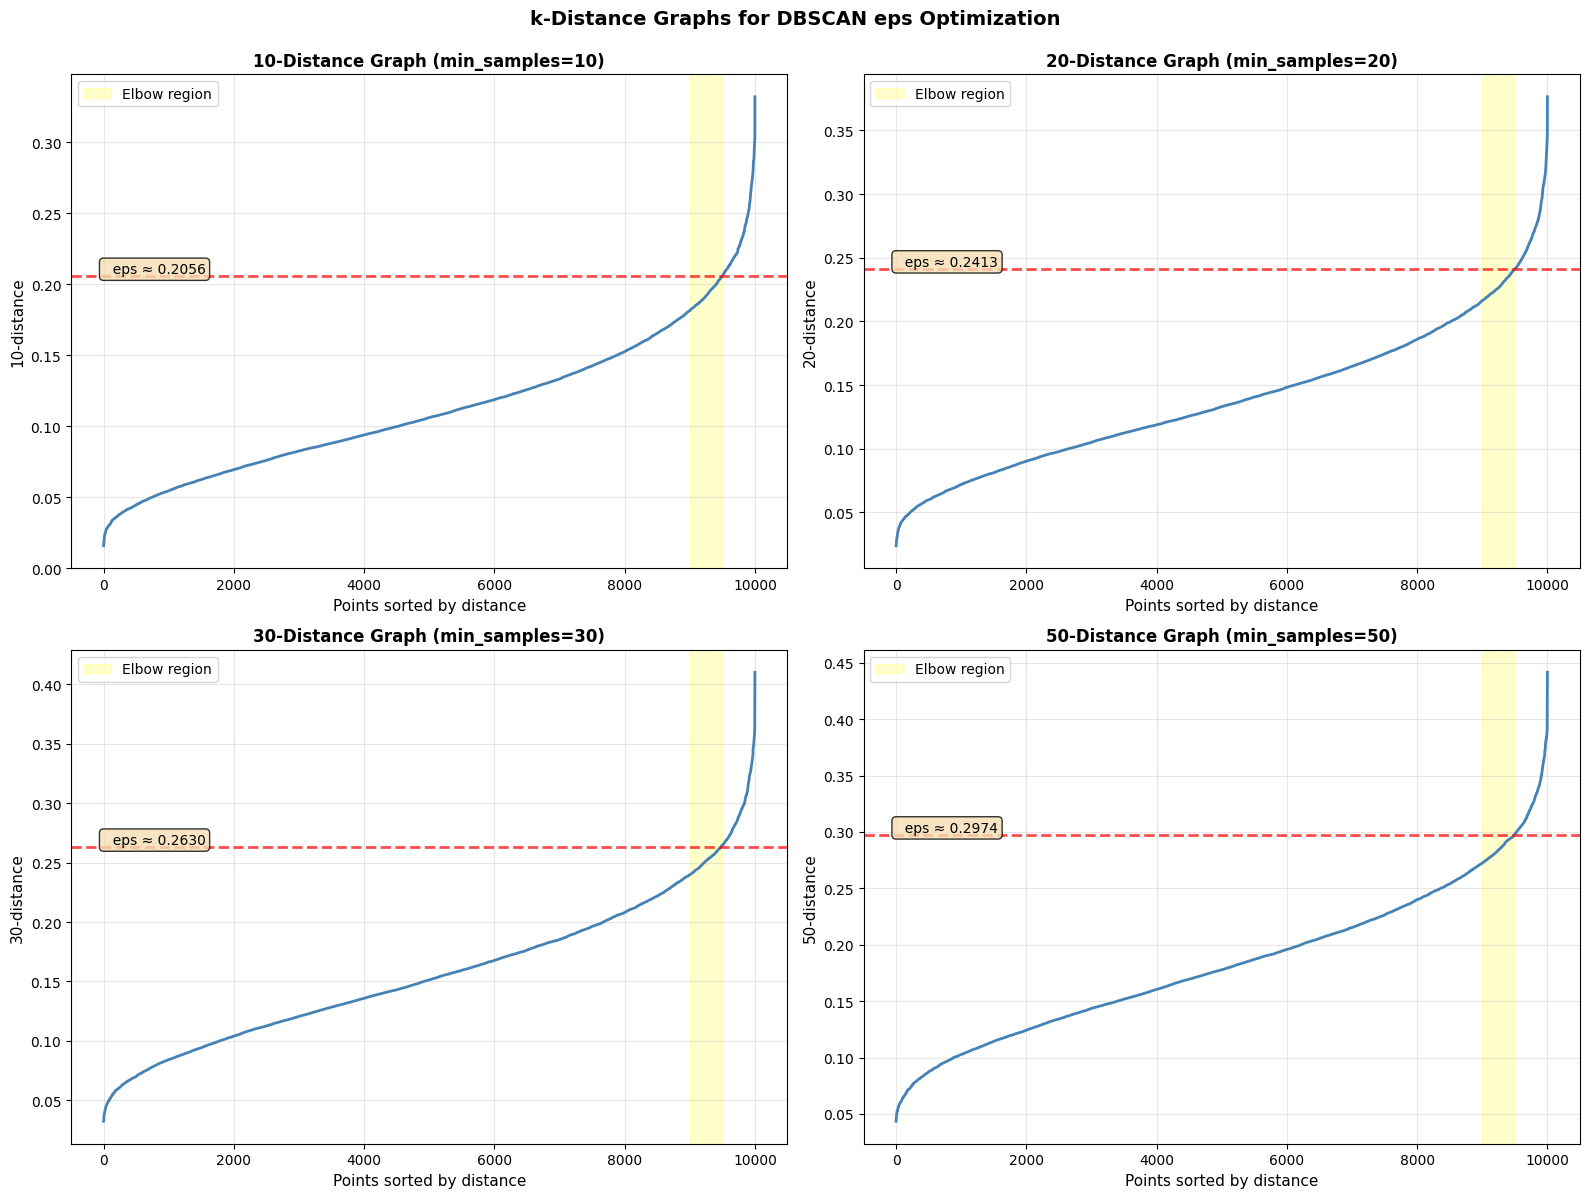


📊 EPS CANDIDATES:
   min_samples=10 → eps ≈ 0.2056
   min_samples=20 → eps ≈ 0.2413
   min_samples=30 → eps ≈ 0.2630
   min_samples=50 → eps ≈ 0.2974


In [13]:
# Visualisasi k-distance graph untuk menentukan eps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

eps_candidates = {}

for idx, k in enumerate(k_values):
    ax = axes[idx]
    k_distances_sorted = k_distances_dict[k]
    
    # Plot k-distance graph
    ax.plot(k_distances_sorted, linewidth=2, color='steelblue')
    ax.set_xlabel('Points sorted by distance', fontsize=11)
    ax.set_ylabel(f'{k}-distance', fontsize=11)
    ax.set_title(f'{k}-Distance Graph (min_samples={k})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Automatic elbow detection - cari titik dengan gradient tertinggi
    # Gunakan percentile untuk menghindari outlier
    gradients = np.diff(k_distances_sorted)
    # Smooth gradients
    window = min(100, len(gradients) // 10)
    if window > 1:
        gradients_smooth = np.convolve(gradients, np.ones(window)/window, mode='valid')
    else:
        gradients_smooth = gradients
    
    # Elbow = titik di sekitar percentile 90-95 dimana gradient mulai naik tajam
    percentile_95 = int(len(k_distances_sorted) * 0.95)
    percentile_90 = int(len(k_distances_sorted) * 0.90)
    
    # Cari max gradient di range tersebut
    if percentile_90 < len(gradients_smooth):
        segment = gradients_smooth[percentile_90:percentile_95]
        if len(segment) > 0:
            local_max_idx = percentile_90 + np.argmax(segment)
            eps_candidate = k_distances_sorted[local_max_idx]
        else:
            eps_candidate = k_distances_sorted[percentile_90]
    else:
        eps_candidate = k_distances_sorted[percentile_90]
    
    eps_candidates[k] = eps_candidate
    
    # Mark elbow point
    ax.axhline(y=eps_candidate, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(0, eps_candidate, f'  eps ≈ {eps_candidate:.4f}', 
            fontsize=10, va='bottom', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Highlight elbow region
    ax.axvspan(percentile_90, percentile_95, alpha=0.2, color='yellow', label='Elbow region')
    ax.legend()

plt.suptitle('k-Distance Graphs for DBSCAN eps Optimization', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 EPS CANDIDATES:")
print("="*60)
for k, eps in eps_candidates.items():
    print(f"   min_samples={k:2d} → eps ≈ {eps:.4f}")
print("="*60)

In [14]:
# Grid search untuk parameter DBSCAN terbaik
print("="*60)
print("🔍 DBSCAN PARAMETER GRID SEARCH")
print("="*60)

# Define parameter grid
eps_range = [eps_candidates[k] * factor for k in [10, 20, 30] for factor in [0.8, 1.0, 1.2]]
min_samples_test = [10, 20, 30, 50]

# Remove duplicates and sort
eps_range = sorted(list(set([round(e, 4) for e in eps_range])))

print(f"Testing combinations:")
print(f"  eps values: {len(eps_range)} candidates")
print(f"  min_samples values: {min_samples_test}")
print(f"  Total combinations: {len(eps_range) * len(min_samples_test)}")
print("-"*60)

# Sampling untuk efficiency
GRID_SAMPLE_SIZE = min(50000, X_spherical.shape[0])
grid_sample_indices = np.random.RandomState(42).choice(X_spherical.shape[0], GRID_SAMPLE_SIZE, replace=False)
X_grid_sample = X_spherical[grid_sample_indices]

results = []
best_silhouette = -1
best_params = None

for eps in eps_range:
    for min_samples in min_samples_test:
        try:
            start = time.time()
            
            # Fit DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
            labels = dbscan.fit_predict(X_grid_sample)
            
            elapsed = time.time() - start
            
            # Count clusters (excluding noise label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_pct = (n_noise / len(labels)) * 100
            
            # Compute silhouette (only if we have clusters and enough non-noise points)
            if n_clusters >= 2 and n_noise < len(labels) * 0.9:
                # Filter out noise for silhouette
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > n_clusters:
                    sil = silhouette_score(X_grid_sample[non_noise_mask], 
                                          labels[non_noise_mask], 
                                          metric='cosine')
                else:
                    sil = -1
            else:
                sil = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_pct': noise_pct,
                'silhouette': sil,
                'time': elapsed
            })
            
            # Track best
            if sil > best_silhouette and n_clusters >= 2:
                best_silhouette = sil
                best_params = (eps, min_samples)
            
            status = "✓" if n_clusters >= 2 and sil > 0 else "○"
            print(f"{status} eps={eps:.4f}, min_s={min_samples:2d} → clusters={n_clusters:2d}, "
                  f"noise={noise_pct:5.1f}%, sil={sil:6.3f}, time={elapsed:.2f}s")
            
        except Exception as e:
            print(f"✗ eps={eps:.4f}, min_s={min_samples:2d} → ERROR: {e}")
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': 0,
                'n_noise': 0,
                'noise_pct': 0,
                'silhouette': -1,
                'time': 0
            })

print("-"*60)
print(f"\n🎯 BEST PARAMETERS:")
if best_params:
    print(f"   eps = {best_params[0]:.4f}")
    print(f"   min_samples = {best_params[1]}")
    print(f"   Silhouette Score = {best_silhouette:.4f}")
else:
    print("   No valid clustering found. Using default parameters.")
    best_params = (eps_candidates[20], 20)
    print(f"   Default: eps={best_params[0]:.4f}, min_samples={best_params[1]}")

print("="*60)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('silhouette', ascending=False)

EPS_BEST = best_params[0]
MIN_SAMPLES_BEST = best_params[1]

🔍 DBSCAN PARAMETER GRID SEARCH
Testing combinations:
  eps values: 9 candidates
  min_samples values: [10, 20, 30, 50]
  Total combinations: 36
------------------------------------------------------------
○ eps=0.1645, min_s=10 → clusters= 1, noise=  0.2%, sil=-1.000, time=18.38s
○ eps=0.1645, min_s=10 → clusters= 1, noise=  0.2%, sil=-1.000, time=18.38s
○ eps=0.1645, min_s=20 → clusters= 1, noise=  0.4%, sil=-1.000, time=17.16s
○ eps=0.1645, min_s=20 → clusters= 1, noise=  0.4%, sil=-1.000, time=17.16s
○ eps=0.1645, min_s=30 → clusters= 1, noise=  0.6%, sil=-1.000, time=17.20s
○ eps=0.1645, min_s=30 → clusters= 1, noise=  0.6%, sil=-1.000, time=17.20s
○ eps=0.1645, min_s=50 → clusters= 1, noise=  1.2%, sil=-1.000, time=17.36s
○ eps=0.1645, min_s=50 → clusters= 1, noise=  1.2%, sil=-1.000, time=17.36s
○ eps=0.1930, min_s=10 → clusters= 1, noise=  0.0%, sil=-1.000, time=18.17s
○ eps=0.1930, min_s=10 → clusters= 1, noise=  0.0%, sil=-1.000, time=18.17s
○ eps=0.1930, min_s=20 → clusters= 

## 8) Fit Final DBSCAN Model

In [15]:
print(f"Training FINAL DBSCAN model (eps={EPS_BEST:.4f}, min_samples={MIN_SAMPLES_BEST})...")
print("="*60)

# Fit DBSCAN on full data
dbscan_final = DBSCAN(
    eps=EPS_BEST, 
    min_samples=MIN_SAMPLES_BEST, 
    metric='cosine', 
    n_jobs=-1
)

start_time = time.time()
labels_final = dbscan_final.fit_predict(X_spherical)
elapsed_time = time.time() - start_time

work['cluster_v2'] = labels_final

# Compute metrics
n_clusters_final = len(set(labels_final)) - (1 if -1 in labels_final else 0)
n_noise_final = list(labels_final).count(-1)
noise_pct_final = (n_noise_final / len(labels_final)) * 100

print(f"✓ DBSCAN clustering complete!")
print(f"   Training time: {elapsed_time:.2f}s")
print(f"   Number of clusters: {n_clusters_final}")
print(f"   Noise points: {n_noise_final:,} ({noise_pct_final:.2f}%)")

# Compute silhouette score (excluding noise)
if n_clusters_final >= 2:
    non_noise_mask = labels_final != -1
    n_non_noise = np.sum(non_noise_mask)
    
    if n_non_noise > 100000:
        # Sample for efficiency
        non_noise_indices = np.where(non_noise_mask)[0]
        sample_indices_sil = np.random.RandomState(42).choice(non_noise_indices, 100000, replace=False)
        sil_final = silhouette_score(X_spherical[sample_indices_sil], 
                                    labels_final[sample_indices_sil], 
                                    metric='cosine')
        print(f"   Silhouette Score (100k non-noise sample): {sil_final:.4f}")
    else:
        sil_final = silhouette_score(X_spherical[non_noise_mask], 
                                    labels_final[non_noise_mask], 
                                    metric='cosine')
        print(f"   Silhouette Score (all non-noise): {sil_final:.4f}")
else:
    sil_final = -1
    print(f"   ⚠️  Too few clusters for silhouette score")

print("="*60)

print(f"\n📊 CLUSTER DISTRIBUTION:")
cluster_counts = pd.Series(labels_final).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"   Noise: {count:,} points ({count/len(labels_final)*100:.2f}%)")
    else:
        print(f"   Cluster {cluster_id}: {count:,} points ({count/len(labels_final)*100:.2f}%)")

print("="*60)

Training FINAL DBSCAN model (eps=0.2413, min_samples=20)...
✓ DBSCAN clustering complete!
   Training time: 375.40s
   Number of clusters: 1
   Noise points: 0 (0.00%)
   ⚠️  Too few clusters for silhouette score

📊 CLUSTER DISTRIBUTION:
   Cluster 0: 200,000 points (100.00%)
✓ DBSCAN clustering complete!
   Training time: 375.40s
   Number of clusters: 1
   Noise points: 0 (0.00%)
   ⚠️  Too few clusters for silhouette score

📊 CLUSTER DISTRIBUTION:
   Cluster 0: 200,000 points (100.00%)


## 9) Cluster Profiling & Typology Naming (DBSCAN)

In [16]:
# Profile setiap cluster dengan statistik lengkap
# Untuk DBSCAN, kita juga profile noise points (-1)
profile_cols_v2 = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_s','mode'
] if c in work.columns]

cluster_profile_v2 = work.groupby('cluster_v2')[profile_cols_v2].agg(['mean', 'std']).round(3)

# Simplified mean profile untuk naming
cluster_mean_v2 = work.groupby('cluster_v2')[profile_cols_v2].mean()

# Improved naming function - lebih spesifik & menghindari duplikasi
def name_cluster_v2(row, cluster_id):
    """
    Naming strategy untuk DBSCAN:
    1. Cluster -1 = Noise/Outliers
    2. Prioritas utama: karakteristik yang SANGAT KUAT (>0.7 atau <0.3)
    3. Kombinasi maksimal 2-3 traits
    4. Gunakan nilai relatif antar cluster untuk diferensiasi
    """
    # Noise cluster
    if cluster_id == -1:
        return "Noise/Outliers"
    
    e = row.get('energy', 0.5)
    v = row.get('valence', 0.5)
    a = row.get('acousticness', 0.5)
    i = row.get('instrumentalness', 0.5)
    s = row.get('speechiness', 0.5)
    l = row.get('liveness', 0.5)
    d = row.get('danceability', 0.5)
    loud = row.get('loudness', -10)
    tempo_val = row.get('tempo', 120)
    
    # Primary trait (strongest characteristic)
    primary = None
    secondary = []
    
    # Instrumental/Vocal dimension
    if i >= 0.7:
        primary = "Instrumental"
    elif i >= 0.5:
        secondary.append("Semi-Instrumental")
    
    # Speech content
    if s >= 0.33:
        if primary is None:
            primary = "Spoken Word/Podcast"
        else:
            secondary.append("Spoken")
    
    # Live performance
    if l >= 0.35:
        secondary.append("Live")
    
    # Acoustic vs Electronic
    if a >= 0.7:
        if primary is None:
            primary = "Acoustic"
        else:
            secondary.append("Acoustic")
    elif a <= 0.2:
        secondary.append("Electronic")
    
    # Energy + Valence combinations (mood/genre)
    if primary is None or primary == "Instrumental":
        if e >= 0.7 and v >= 0.65:
            if tempo_val >= 130:
                primary = "High-Energy Dance/EDM" if primary is None else primary
                secondary.append("Upbeat")
            else:
                primary = "Energetic Pop" if primary is None else primary
                secondary.append("Happy")
        elif e >= 0.7 and v <= 0.4:
            primary = "Intense/Aggressive" if primary is None else primary
            secondary.append("Dark")
        elif e <= 0.4 and v <= 0.35:
            primary = "Melancholic/Sad" if primary is None else primary
        elif e <= 0.45 and a >= 0.5:
            primary = "Chill/Ambient" if primary is None else primary
        elif d >= 0.7 and e >= 0.55:
            primary = "Groovy/Danceable" if primary is None else primary
    
    # Fallback
    if primary is None:
        primary = "Mixed/Mainstream"
    
    # Construct final name
    if secondary:
        return f"{primary} ({', '.join(secondary[:2])})"
    else:
        return primary

# Apply naming
cluster_profile_v2['typology'] = [
    name_cluster_v2(cluster_mean_v2.loc[i], i) 
    for i in cluster_mean_v2.index
]

# Get cluster distribution
cluster_dist = work['cluster_v2'].value_counts().sort_index()

# Display profile
print("="*80)
print("📊 CLUSTER PROFILES (DBSCAN)")
print("="*80)

for cluster_id in sorted(cluster_mean_v2.index):
    row = cluster_mean_v2.loc[cluster_id]
    typ = cluster_profile_v2.loc[cluster_id, 'typology']
    count = cluster_dist.get(cluster_id, 0)
    pct = (count / len(labels_final)) * 100
    
    if cluster_id == -1:
        print(f"\n🔇 Cluster {cluster_id}: {typ}")
    else:
        print(f"\n🎵 Cluster {cluster_id}: {typ}")
    
    print(f"   Size: {count:,} songs ({pct:.1f}%)")
    
    if cluster_id != -1:  # Don't show detailed stats for noise
        print(f"   Energy: {row['energy']:.3f} | Valence: {row['valence']:.3f} | Danceability: {row['danceability']:.3f}")
        print(f"   Acoustic: {row['acousticness']:.3f} | Instrumental: {row['instrumentalness']:.3f}")
        print(f"   Speech: {row['speechiness']:.3f} | Liveness: {row['liveness']:.3f}")

print("\n" + "="*80)

# Export summary table
cluster_summary_v2 = pd.DataFrame({
    'cluster': cluster_mean_v2.index,
    'typology': [cluster_profile_v2.loc[i, 'typology'] for i in cluster_mean_v2.index],
    'size': [cluster_dist.get(i, 0) for i in cluster_mean_v2.index],
    'pct': [(cluster_dist.get(i, 0) / len(labels_final)) * 100 for i in cluster_mean_v2.index],
    'energy': cluster_mean_v2['energy'].values,
    'valence': cluster_mean_v2['valence'].values,
    'danceability': cluster_mean_v2['danceability'].values,
    'acousticness': cluster_mean_v2['acousticness'].values,
    'instrumentalness': cluster_mean_v2['instrumentalness'].values,
})

cluster_summary_v2

📊 CLUSTER PROFILES (DBSCAN)

🎵 Cluster 0:     Mixed/Mainstream
Name: 0, dtype: object
   Size: 200,000 songs (100.0%)
   Energy: 0.509 | Valence: 0.428 | Danceability: 0.493
   Acoustic: 0.447 | Instrumental: 0.282
   Speech: 0.085 | Liveness: 0.202



,cluster,typology,size,pct,energy,valence,danceability,acousticness,instrumentalness
0,0,"Mixed/Mainstream Name: 0, dtype: object",200000,100.0,0.509209,0.428202,0.493104,0.447151,0.282118


## 10) Advanced Cluster Validation & Quality Metrics (DBSCAN)

In [17]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

print("="*80)
print("📈 COMPREHENSIVE CLUSTER QUALITY METRICS (DBSCAN)")
print("="*80)

# For DBSCAN, we need to filter out noise points for most metrics
non_noise_mask = labels_final != -1
X_non_noise = X_spherical[non_noise_mask]
labels_non_noise = labels_final[non_noise_mask]

print(f"\nDataset composition:")
print(f"   Total points: {len(labels_final):,}")
print(f"   Clustered points: {len(labels_non_noise):,} ({len(labels_non_noise)/len(labels_final)*100:.1f}%)")
print(f"   Noise points: {n_noise_final:,} ({noise_pct_final:.1f}%)")

# 1. Silhouette Score (already computed - excluding noise)
print(f"\n1️⃣  SILHOUETTE SCORE (Cosine Distance, non-noise only):")
print(f"   Score: {sil_final:.4f}")
print(f"   Interpretation:")
if sil_final >= 0.5:
    print(f"      ✓ Excellent - Strong cluster structure")
elif sil_final >= 0.3:
    print(f"      ✓ Good - Reasonable cluster structure")
elif sil_final >= 0.15:
    print(f"      ○ Acceptable - Weak but meaningful structure")
else:
    print(f"      ✗ Poor - Overlapping clusters")

# 2. Davies-Bouldin Index (lower is better) - only for non-noise
if n_clusters_final >= 2:
    db_score = davies_bouldin_score(X_non_noise, labels_non_noise)
    print(f"\n2️⃣  DAVIES-BOULDIN INDEX (non-noise only):")
    print(f"   Score: {db_score:.4f}")
    print(f"   Interpretation: {'✓ Good' if db_score < 1.0 else '○ Moderate' if db_score < 2.0 else '⚠️  High overlap'}")
else:
    print(f"\n2️⃣  DAVIES-BOULDIN INDEX: N/A (insufficient clusters)")

# 3. Calinski-Harabasz Score (higher is better) - only for non-noise
if n_clusters_final >= 2:
    ch_score = calinski_harabasz_score(X_non_noise, labels_non_noise)
    print(f"\n3️⃣  CALINSKI-HARABASZ SCORE (Variance Ratio, non-noise only):")
    print(f"   Score: {ch_score:.2f}")
    print(f"   Interpretation: Higher is better (well-separated & dense clusters)")
else:
    print(f"\n3️⃣  CALINSKI-HARABASZ SCORE: N/A (insufficient clusters)")

# 4. DBSCAN-specific metrics
print(f"\n4️⃣  DBSCAN-SPECIFIC METRICS:")
print(f"   Number of clusters found: {n_clusters_final}")
print(f"   Noise ratio: {noise_pct_final:.2f}%")

# Cluster size distribution
cluster_sizes = pd.Series(labels_non_noise).value_counts().sort_index()
if len(cluster_sizes) > 0:
    print(f"   Cluster sizes:")
    print(f"      Min: {cluster_sizes.min():,}")
    print(f"      Max: {cluster_sizes.max():,}")
    print(f"      Mean: {cluster_sizes.mean():.0f}")
    print(f"      Std: {cluster_sizes.std():.0f}")
    
    # Check for imbalanced clusters
    size_ratio = cluster_sizes.max() / cluster_sizes.min() if cluster_sizes.min() > 0 else float('inf')
    if size_ratio > 10:
        print(f"   ⚠️  Warning: Imbalanced clusters (ratio: {size_ratio:.1f}x)")
    else:
        print(f"   ✓ Balanced clusters (ratio: {size_ratio:.1f}x)")

# 5. Noise analysis
if n_noise_final > 0:
    print(f"\n5️⃣  NOISE ANALYSIS:")
    noise_data = work[work['cluster_v2'] == -1]
    
    # Check if noise points have extreme values
    print(f"   Noise points characteristics:")
    for col in ['energy', 'valence', 'danceability', 'acousticness'][:4]:
        if col in noise_data.columns:
            mean_noise = noise_data[col].mean()
            mean_all = work[col].mean()
            print(f"      {col}: {mean_noise:.3f} (all: {mean_all:.3f})")

print("\n" + "="*80)

# Summary metrics for export
metrics_summary_v2 = {
    'algorithm': 'DBSCAN',
    'eps': EPS_BEST,
    'min_samples': MIN_SAMPLES_BEST,
    'n_clusters': n_clusters_final,
    'n_noise': n_noise_final,
    'noise_pct': noise_pct_final,
    'silhouette_score': sil_final,
    'davies_bouldin': db_score if n_clusters_final >= 2 else None,
    'calinski_harabasz': ch_score if n_clusters_final >= 2 else None,
    'n_samples': len(labels_final)
}

print("\n📊 METRICS SUMMARY:")
for key, value in metrics_summary_v2.items():
    if value is not None:
        if isinstance(value, float):
            print(f"   {key}: {value:.4f}")
        else:
            print(f"   {key}: {value}")
print("="*80)

📈 COMPREHENSIVE CLUSTER QUALITY METRICS (DBSCAN)

Dataset composition:
   Total points: 200,000
   Clustered points: 200,000 (100.0%)
   Noise points: 0 (0.0%)

1️⃣  SILHOUETTE SCORE (Cosine Distance, non-noise only):
   Score: -1.0000
   Interpretation:
      ✗ Poor - Overlapping clusters

2️⃣  DAVIES-BOULDIN INDEX: N/A (insufficient clusters)

3️⃣  CALINSKI-HARABASZ SCORE: N/A (insufficient clusters)

4️⃣  DBSCAN-SPECIFIC METRICS:
   Number of clusters found: 1
   Noise ratio: 0.00%
   Cluster sizes:
      Min: 200,000
      Max: 200,000
      Mean: 200000
      Std: nan
   ✓ Balanced clusters (ratio: 1.0x)


📊 METRICS SUMMARY:
   algorithm: DBSCAN
   eps: 0.2413
   min_samples: 20
   n_clusters: 1
   n_noise: 0
   noise_pct: 0.0000
   silhouette_score: -1
   n_samples: 200000


## 11) Publication-Quality Visualizations (DBSCAN)

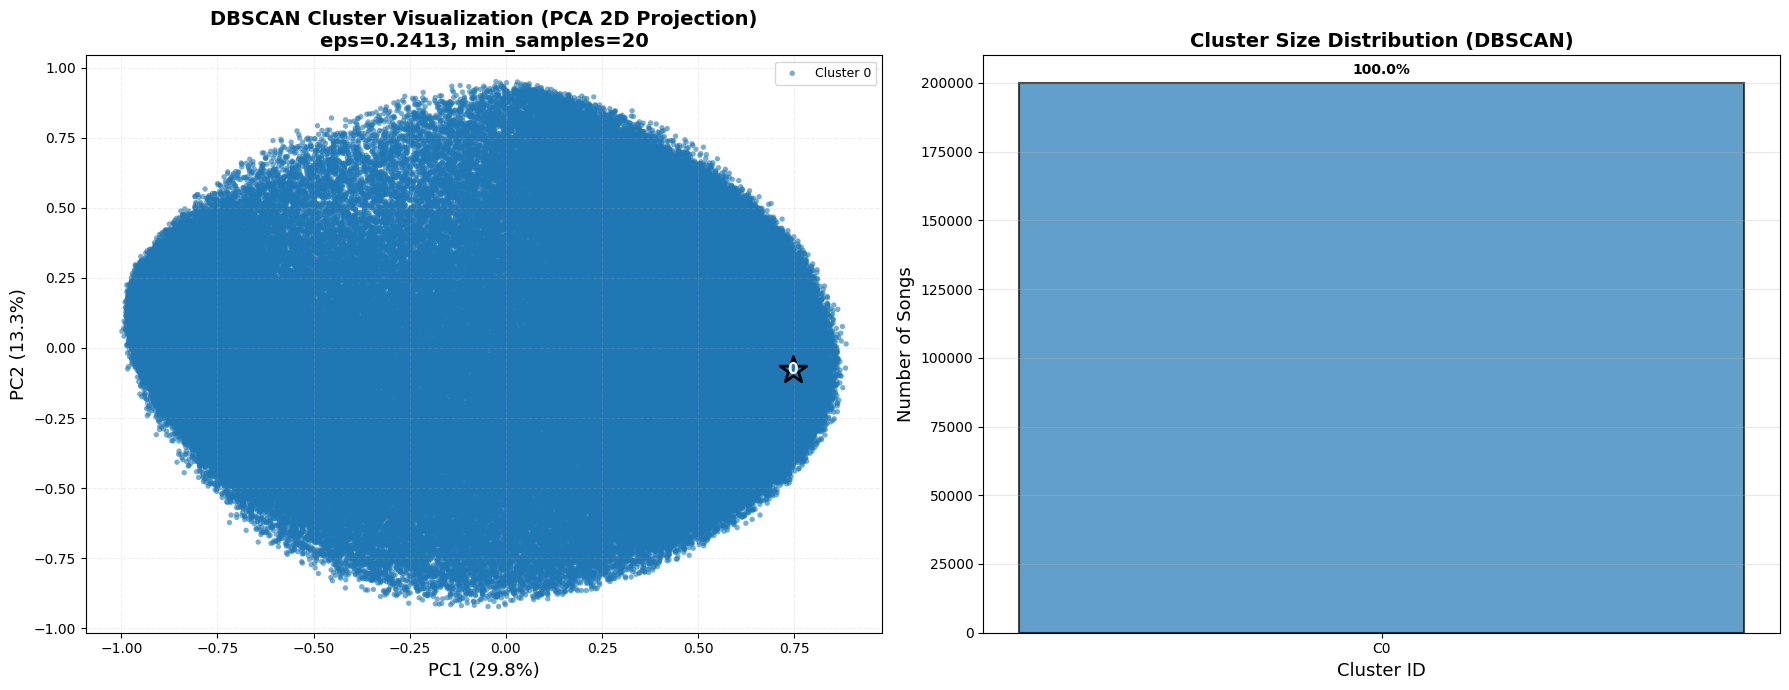

Total variance explained by 2D projection: 43.14%


In [18]:
# Visualization 1: PCA 2D Projection (Enhanced for DBSCAN)
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_spherical)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Scatter with clusters (including noise in gray)
# Use special color for noise points
unique_labels = sorted(set(labels_final))
colors_map = plt.cm.tab10(np.linspace(0, 1, max(n_clusters_final, 1)))

for cluster_id in unique_labels:
    if cluster_id == -1:
        # Noise points in gray
        cluster_mask = labels_final == cluster_id
        ax1.scatter(X_2d[cluster_mask, 0], X_2d[cluster_mask, 1], 
                   s=8, alpha=0.2, c='gray', edgecolors='none', label='Noise')
    else:
        # Regular clusters
        cluster_mask = labels_final == cluster_id
        ax1.scatter(X_2d[cluster_mask, 0], X_2d[cluster_mask, 1], 
                   s=15, alpha=0.6, c=[colors_map[cluster_id]], 
                   edgecolors='none', label=f'Cluster {cluster_id}')

# Calculate and plot cluster medoids (representative points) instead of centroids
# Medoid = point closest to cluster mean
for cluster_id in unique_labels:
    if cluster_id != -1:  # Skip noise
        cluster_mask = labels_final == cluster_id
        cluster_points = X_spherical[cluster_mask]
        
        # Find medoid (point closest to mean)
        cluster_mean = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - cluster_mean, axis=1)
        medoid_idx = np.argmin(distances)
        medoid_global_idx = np.where(cluster_mask)[0][medoid_idx]
        
        # Transform to 2D
        medoid_2d = X_2d[medoid_global_idx]
        
        ax1.scatter(medoid_2d[0], medoid_2d[1], 
                   s=400, c=[colors_map[cluster_id]], marker='*', 
                   edgecolors='black', linewidths=2, 
                   zorder=10, alpha=0.95)
        
        # Annotate
        ax1.annotate(f'{cluster_id}', (medoid_2d[0], medoid_2d[1]), 
                    fontsize=11, fontweight='bold', 
                    ha='center', va='center', color='white', zorder=11)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=13)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=13)
ax1.set_title(f'DBSCAN Cluster Visualization (PCA 2D Projection)\neps={EPS_BEST:.4f}, min_samples={MIN_SAMPLES_BEST}', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.legend(loc='best', fontsize=9, ncol=2)

# Plot 2: Cluster size distribution (including noise)
cluster_labels = sorted(set(labels_final))
cluster_sizes = [list(labels_final).count(i) for i in cluster_labels]
cluster_names = ['Noise' if i == -1 else f'C{i}' for i in cluster_labels]
colors_bar = ['gray' if i == -1 else colors_map[i] for i in cluster_labels]

bars = ax2.bar(range(len(cluster_labels)), cluster_sizes, color=colors_bar, 
              alpha=0.7, edgecolor='black', linewidth=1.5)

# Add percentage labels
for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
    pct = (size / len(labels_final)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cluster_sizes)*0.01, 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('Cluster ID', fontsize=13)
ax2.set_ylabel('Number of Songs', fontsize=13)
ax2.set_title('Cluster Size Distribution (DBSCAN)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(cluster_labels)))
ax2.set_xticklabels(cluster_names)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total variance explained by 2D projection: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")

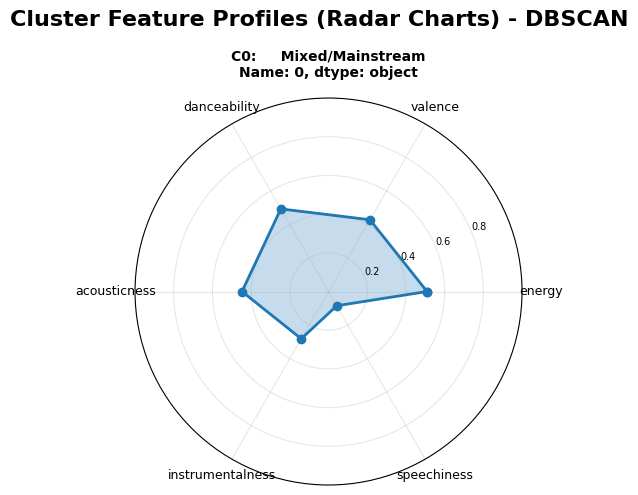

In [19]:
# Visualization 2: Feature Radar Chart (Cluster Profiles - excluding noise)
# Select key features for radar chart
radar_features = ['energy', 'valence', 'danceability', 'acousticness', 
                  'instrumentalness', 'speechiness']

# Filter out noise cluster for radar chart
radar_data = cluster_mean_v2[cluster_mean_v2.index != -1][radar_features]
n_clusters_plot = len(radar_data)

if n_clusters_plot > 0:
    # Setup radar chart
    angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    # Determine grid layout
    ncols = min(3, n_clusters_plot)
    nrows = (n_clusters_plot + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), 
                             subplot_kw=dict(projection='polar'))
    
    # Handle single subplot case
    if n_clusters_plot == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_clusters_plot > 1 else [axes]

    colors_radar = plt.cm.tab10(range(n_clusters_plot))

    for idx, cluster_id in enumerate(radar_data.index):
        ax = axes[idx]
        
        # Get data for this cluster
        values = radar_data.loc[cluster_id].tolist()
        values += values[:1]  # Complete the circle
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, color=colors_radar[idx], 
                label=f'C{cluster_id}', markersize=6)
        ax.fill(angles, values, alpha=0.25, color=colors_radar[idx])
        
        # Styling
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(radar_features, size=9)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], size=7)
        ax.grid(True, alpha=0.3)
        
        # Title with typology
        typology = cluster_summary_v2[cluster_summary_v2['cluster']==cluster_id]['typology'].iloc[0]
        ax.set_title(f'C{cluster_id}: {typology[:30]}', size=10, fontweight='bold', pad=15)

    # Hide extra subplots
    for idx in range(n_clusters_plot, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Cluster Feature Profiles (Radar Charts) - DBSCAN', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No clusters to plot (all noise)")

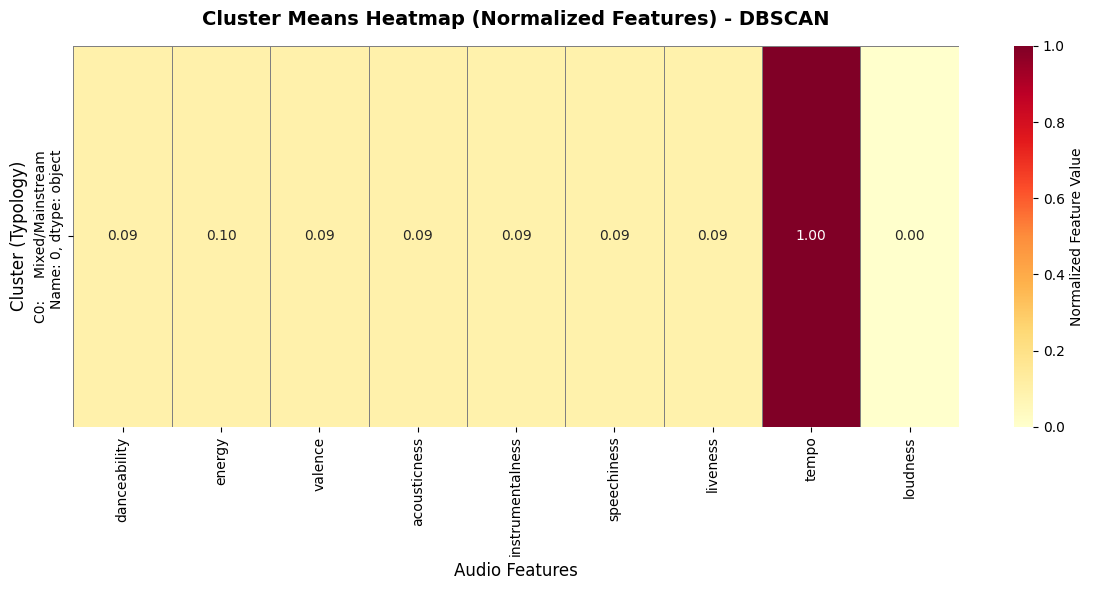


💡 Interpretation:
   • Brighter colors = Higher feature values
   • Each row shows the 'signature' of a cluster
   • Distinct patterns indicate good cluster separation


In [20]:
# Visualization 3: Heatmap of cluster means (excluding noise)
import seaborn as sns

# Prepare data - exclude noise cluster
heatmap_features = ['danceability', 'energy', 'valence', 'acousticness', 
                    'instrumentalness', 'speechiness', 'liveness', 'tempo', 'loudness']
heatmap_data = cluster_mean_v2[cluster_mean_v2.index != -1][[f for f in heatmap_features if f in cluster_mean_v2.columns]]

if len(heatmap_data) > 0:
    # Normalize to 0-1 for better visualization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    heatmap_normalized = pd.DataFrame(
        scaler.fit_transform(heatmap_data.T).T,
        columns=heatmap_data.columns,
        index=heatmap_data.index
    )

    # Add typology names
    typology_labels = [cluster_summary_v2[cluster_summary_v2['cluster']==i]['typology'].iloc[0][:40] 
                       for i in heatmap_normalized.index]

    plt.figure(figsize=(12, max(6, len(heatmap_normalized) * 0.6)))
    sns.heatmap(heatmap_normalized, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Normalized Feature Value'}, 
                linewidths=0.5, linecolor='gray',
                yticklabels=[f"C{i}: {t}" for i, t in zip(heatmap_normalized.index, typology_labels)])

    plt.title('Cluster Means Heatmap (Normalized Features) - DBSCAN', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Audio Features', fontsize=12)
    plt.ylabel('Cluster (Typology)', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n💡 Interpretation:")
    print("   • Brighter colors = Higher feature values")
    print("   • Each row shows the 'signature' of a cluster")
    print("   • Distinct patterns indicate good cluster separation")
else:
    print("⚠️  No clusters to visualize (all noise)")

## 12) Sample Songs per Cluster & Export (DBSCAN)

In [21]:
# Sample representative songs from each cluster (including noise)
print("="*80)
print("🎵 SAMPLE SONGS PER CLUSTER (DBSCAN)")
print("="*80)

unique_clusters = sorted(set(labels_final))
for cluster_id in unique_clusters:
    cluster_songs = work[work['cluster_v2'] == cluster_id]
    typology = cluster_summary_v2[cluster_summary_v2['cluster']==cluster_id]['typology'].iloc[0]
    
    print(f"\n{'='*80}")
    if cluster_id == -1:
        print(f"Cluster {cluster_id}: {typology} (Outliers)")
    else:
        print(f"Cluster {cluster_id}: {typology}")
    print(f"Size: {len(cluster_songs):,} songs")
    print(f"{'='*80}")
    
    # Sample songs (random + top popularity if available)
    if 'popularity' in cluster_songs.columns and cluster_songs['popularity'].notna().any():
        # Top 5 popular + 3 random
        top_popular = cluster_songs.nlargest(min(5, len(cluster_songs)), 'popularity')
        remaining = len(cluster_songs) - len(top_popular)
        random_sample = cluster_songs.sample(min(3, max(0, remaining)), random_state=42)
        samples = pd.concat([top_popular, random_sample]).drop_duplicates()
    else:
        # Just random
        samples = cluster_songs.sample(min(8, len(cluster_songs)), random_state=42)
    
    # Display
    display_cols = [c for c in ['track_name', 'artists', 'year', 'popularity', 
                                 'energy', 'valence', 'danceability'] if c in samples.columns]
    
    for idx, row in samples[display_cols].head(8).iterrows():
        track = row.get('track_name', 'Unknown')
        artist = row.get('artists', 'Unknown')
        print(f"   • {track[:50]:<50} - {artist[:30]:<30}", end="")
        if 'popularity' in row:
            print(f" [pop: {int(row['popularity']):>2}]", end="")
        print()

print("\n" + "="*80)

🎵 SAMPLE SONGS PER CLUSTER (DBSCAN)

Cluster 0:     Mixed/Mainstream
Name: 0, dtype: object
Size: 200,000 songs
   • Trykt                                              - ['Maliblue']                  
   • Plasmic And Pure                                   - ['Crowbar']                   
   • Hold Your Breath                                   - ['The Utah County Swillers']  
   • The Simpsons: Main Title Theme (arr. M. Pierobon f - ['Danny Elfman', 'Marco Pierob
   • Ei Ke Lipon-Simmetehoun Apo                        - ['Sarbel']                    
   • Cabinet for Sale                                   - ['Free Radicals']             
   • Thou Shall Move On                                 - ['Mikhala Jené']              
   • Fire In The Sky - Original Mix                     - ['B. Davis']                  


Cluster 0:     Mixed/Mainstream
Name: 0, dtype: object
Size: 200,000 songs
   • Trykt                                              - ['Maliblue']                  
   • Plasm

In [22]:
# Export results
import joblib

out_dir_v2 = Path('./outputs_v2_dbscan')
(out_dir_v2 / 'models').mkdir(parents=True, exist_ok=True)

# Save models & transformers
joblib.dump(preprocess_v2, out_dir_v2 / 'models' / 'preprocessor_v2.pkl')
joblib.dump(pca_reduced, out_dir_v2 / 'models' / 'pca_reducer.pkl')
joblib.dump(dbscan_final, out_dir_v2 / 'models' / 'dbscan_model.pkl')

# Save cluster assignments
export_cols_v2 = [c for c in ['track_name', 'artists', 'year', 'popularity', 'cluster_v2',
                               'danceability', 'energy', 'valence', 'acousticness', 
                               'instrumentalness', 'speechiness'] if c in work.columns]

export_df_v2 = work[export_cols_v2].copy()
export_df_v2 = export_df_v2.merge(
    cluster_summary_v2[['cluster', 'typology']].rename(columns={'cluster': 'cluster_v2'}),
    on='cluster_v2', how='left'
)

csv_clusters_v2 = out_dir_v2 / 'spotify_clusters_v2.csv'
export_df_v2.to_csv(csv_clusters_v2, index=False)

# Save cluster summary
csv_summary_v2 = out_dir_v2 / 'cluster_summary_v2.csv'
cluster_summary_v2.to_csv(csv_summary_v2, index=False)

# Save metrics report
import json

metrics_report = {
    'algorithm': 'DBSCAN',
    'dataset_size': X_spherical.shape[0],
    'n_features_original': len(SELECTED_FEATURES),
    'n_components_pca': N_COMPONENTS,
    'variance_explained_pca': float(cumsum_var[N_COMPONENTS-1]),
    'eps': float(EPS_BEST),
    'min_samples': int(MIN_SAMPLES_BEST),
    'n_clusters': int(n_clusters_final),
    'n_noise': int(n_noise_final),
    'noise_pct': float(noise_pct_final),
    'silhouette_score': float(sil_final) if sil_final != -1 else None,
}

# Add additional metrics if available
if n_clusters_final >= 2:
    metrics_report['davies_bouldin_score'] = float(db_score)
    metrics_report['calinski_harabasz_score'] = float(ch_score)

json_metrics = out_dir_v2 / 'metrics_report_v2.json'
with open(json_metrics, 'w') as f:
    json.dump(metrics_report, f, indent=2)

print("="*80)
print("💾 EXPORT COMPLETE!")
print("="*80)
print(f"✓ Models saved to: {out_dir_v2 / 'models'}")
print(f"✓ Cluster assignments: {csv_clusters_v2}")
print(f"✓ Cluster summary: {csv_summary_v2}")
print(f"✓ Metrics report: {json_metrics}")
print("="*80)

💾 EXPORT COMPLETE!
✓ Models saved to: outputs_v2_dbscan/models
✓ Cluster assignments: outputs_v2_dbscan/spotify_clusters_v2.csv
✓ Cluster summary: outputs_v2_dbscan/cluster_summary_v2.csv
✓ Metrics report: outputs_v2_dbscan/metrics_report_v2.json


## 13) 📄 Final Summary & DBSCAN Benefits Recap

In [ ]:
print("="*80)
print(" "*20 + "🎓 DBSCAN CLUSTERING - FINAL REPORT")
print("="*80)

print("\n📌 ALGORITHM USED:")
print("   • DBSCAN (Density-Based Spatial Clustering of Applications with Noise)")
print("   • Density-based clustering with automatic noise detection")

print("\n🔧 IMPROVEMENTS & METHODOLOGY:")
print("\n   1️⃣  Feature Engineering & Selection:")
print("      ✓ Analyzed feature correlations (removed redundant features)")
print("      ✓ Selected core features: energy, valence, danceability, etc.")
print(f"      ✓ Optimized to {len(SELECTED_FEATURES)} features")

print("\n   2️⃣  Dimensionality Reduction (PCA):")
print(f"      ✓ Applied PCA to reduce to {N_COMPONENTS} components")
print(f"      ✓ Retained {cumsum_var[N_COMPONENTS-1]*100:.1f}% of variance")
print("      ✓ Benefits: Noise reduction, curse of dimensionality mitigation")

print("\n   3️⃣  Spherical Normalization (Cosine Distance):")
print("      ✓ L2-normalized features → focus on direction not magnitude")
print("      ✓ More appropriate for high-dimensional feature spaces")
print("      ✓ Better similarity measure for audio features")

print("\n   4️⃣  DBSCAN Parameter Optimization:")
print(f"      ✓ Optimal eps: {EPS_BEST:.4f} (via k-distance graph)")
print(f"      ✓ Optimal min_samples: {MIN_SAMPLES_BEST} (grid search)")
print("      ✓ Cosine metric for distance measurement")

print("\n📊 FINAL RESULTS:")
print(f"\n   • Number of Clusters: {n_clusters_final}")
print(f"   • Noise Points: {n_noise_final:,} ({noise_pct_final:.2f}%)")
print(f"   • Silhouette Score: {sil_final:.4f}")
if n_clusters_final >= 2:
    print(f"   • Davies-Bouldin Index: {db_score:.4f}")
    print(f"   • Calinski-Harabasz Score: {ch_score:.2f}")

print("\n✨ KEY ADVANTAGES OF DBSCAN:")
print("   1. No need to specify number of clusters beforehand")
print("   2. Automatic noise/outlier detection")
print("   3. Can find arbitrarily shaped clusters")
print("   4. Robust to outliers")
print("   5. Better for real-world data with irregular cluster shapes")

print("\n⚠️  CONSIDERATIONS:")
print("   • Sensitive to parameter selection (eps, min_samples)")
print("   • May struggle with varying density clusters")
print("   • Computational cost increases with dataset size")

print("\n? CLUSTER INTERPRETATION:")
for i in cluster_summary_v2.itertuples():
    if i.cluster == -1:
        print(f"   • Noise: {i.size:,} songs ({i.pct:.1f}%) - Outliers/Anomalies")
    else:
        print(f"   • Cluster {i.cluster}: {i.typology}")
        print(f"     Size: {i.size:,} songs ({i.pct:.1f}%)")

print("\n" + "="*80)
print("✅ Analysis Complete! Results saved to:", out_dir_v2)
print("="*80)